In [127]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

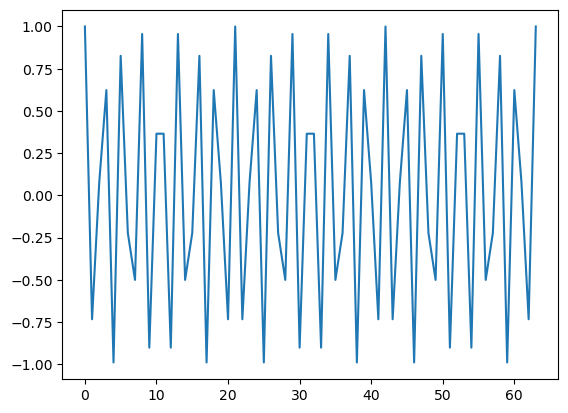

In [87]:
N = 64
t = np.arange(0,2*np.pi,2*np.pi/(N-1))
t = np.linspace(0,2*np.pi,N)
f = 24
s = np.cos(f*t)+1j*np.sin(f*t)
plt.plot(np.real(s))

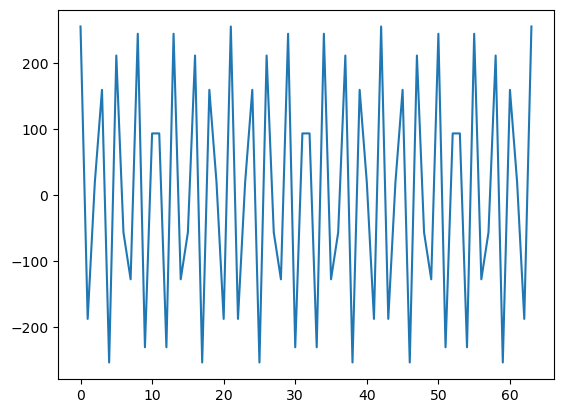

In [121]:
## floating to fixed point conversion
def floating_to_fixed(val,backoff):
    if val < 0:
        out = np.int16(val * 2**15)
    else:
        out = np.int16(val * (2**15 - 1))
    out = out >> backoff
    return out

def floating_to_fixed_new(val,backoff):
    if val < 0:
        step_sz = 1/(2**14)
        out = np.int16(np.round(val/step_sz))
    else:
        step_sz = 1/(2**14)
        out = np.int16(np.round(val/step_sz))
    out = out >> backoff
    return out

def floating_to_fixed_comp(x:complex,backoff:int):
    re = floating_to_fixed_new(np.real(x),backoff)
    im = floating_to_fixed_new(np.imag(x),backoff)
    out = re + 1j * im
    return out

def floating_to_fixed_arr(x:np.ndarray,backoff):
    for i in range(x.size):
        x[i] = floating_to_fixed_comp(x[i],backoff)
    return x

s_fixed = np.zeros(N,dtype=np.complex64)
backoff = 7
for i in range(s.size):
    tmpOutr = floating_to_fixed(np.real(s[i]),backoff)
    tmpOuti = floating_to_fixed(np.imag(s[i]),backoff)
    s_fixed[i] = tmpOutr + 1j * tmpOuti

plt.plot(np.real(s_fixed))

In [122]:
def get_reversed_idx(index):
    N = index.size
    exp = np.emath.logn(4,N)
    num_bits = np.emath.logn(2,N)
    num_shifts = (int(exp) + 1) // 2
    max_shift = (int(exp)-1)*2
    reversed_index = np.zeros(N,dtype=int)
    for i in index:
        tmp = int(0)
        shift = max_shift
        for j in range(num_shifts):
            tmp = tmp | (((3<<(j*2))&i)<<shift) | (((3<<(max_shift-j*2))&i)>>shift)
            shift = shift - 4
        reversed_index[i] = tmp
    return reversed_index

index = np.arange(0,16,dtype=int)
reversed_index = get_reversed_idx(index)
print(reversed_index)

[ 0  4  8 12  1  5  9 13  2  6 10 14  3  7 11 15]


In [125]:
## radix 4 DIT
def radix_4_core(x:np.ndarray[np.complex64], tw:np.ndarray[np.complex64]) -> np.ndarray[np.complex64]:
    out = np.zeros(x.size, dtype=np.complex64)
    for i in range(4):
        out[i] = np.dot(x, tw[:,i])
    return out


def get_complex_exp(k:float) -> complex:
    w = 2*np.pi*k
    out = np.cos(w) - 1j*np.sin(w)
    return out


def get_twiddle_matrix(stage, idx:np.ndarray[int]) -> np.ndarray[np.complex64]:
    out = np.zeros([4, 4], dtype=np.complex64)
    #assert idx.size == (4**stage), f"No of input points in stage: {stage} should be: {4**stage}"
    for i in range(4):
        for j in range(4):
            out[i][j] = get_complex_exp(idx[i]*j/(4**stage))
    return out


def radix_4_pre(x:np.ndarray[np.complex64]) -> np.ndarray[np.complex64]:
    N = x.size
    num_stages = int(np.emath.logn(4,N))
    index = np.arange(0,N,dtype=int)
    reversed_index = get_reversed_idx(index)
    stage_out = np.copy(x)
    print(x)
    
    for s in range(num_stages):
        num_butterflies_per_group = 4**s
        num_points_per_group = num_butterflies_per_group*4
        num_groups = N//num_points_per_group
        num_points_per_butt = 4

        for g in range(num_groups):
            for b in range(num_butterflies_per_group):
                i = (g+b)*num_points_per_butt
                chosen_idx = reversed_index[i:i+4]
                chosen_inpt = stage_out[chosen_idx]
                twiddle_mat = get_twiddle_matrix(s+1, chosen_idx)
                #print("s",s)
                #print(twiddle_mat)
                if s == 1:
                    out_idx = chosen_idx
                else:
                    out_idx = range(i,i+4)
                print("ip idx:",chosen_idx)
                #print("op idx:",out_idx)
                print("op idx:",chosen_inpt)
                stage_out[out_idx] = radix_4_core(chosen_inpt, twiddle_mat)

        if s==0:
            print(stage_out)

    return stage_out

def bit_reversed_order(x, N):
    """Reorder the input array to match Radix-4 bit-reversed order."""
    log4_N = int(np.log2(N) / 2)  # log4(N) for radix-4
    reordered = np.zeros(N, dtype=complex)
    for i in range(N):
        rev_index = int('{:04b}'.format(i)[::-1], 4)  # Bit-reversal in base-4
        s = '{:04b}'.format(i)
        rev_index = int(''.join([s[i:i+2] for i in range(0, len(s), 2)][::-1]),2)
        print(rev_index)
        reordered[i] = x[rev_index]
    return reordered

def radix4_fft16(x):
    """Computes a 16-point FFT using Radix-4 DIT"""
    N = len(x)
    assert N == 16, "This implementation is for 16-point FFT only."

    # Step 2: Compute four 4-point FFTs (first stage)
    X = np.zeros(N, dtype=complex)
    backoff=0
    for i in range(4):
        sub_x = x[i*4:i*4+4]
        #print(sub_x)
        X[i*4]   = sub_x[0] + sub_x[1] + sub_x[2] + sub_x[3]
        X[i*4+1] = sub_x[0] + sub_x[1]*(-1j) + sub_x[2]*(-1) + sub_x[3]*(1j)
        X[i*4+2] = sub_x[0] + sub_x[1]*(-1) + sub_x[2] + sub_x[3]*(-1)
        X[i*4+3] = sub_x[0] + sub_x[1]*(1j) + sub_x[2]*(-1) + sub_x[3]*(-1j)

    #print(X)

    # Step 3: Apply twiddle factors and combine (second stage)
    X_final = np.zeros(16, dtype=complex)

    for k in range(4):
        W16 = np.exp(-1j * 2 * np.pi * k * np.arange(4) / 16)  # Twiddle factors for 16-point FFT
        print(W16)
        W16 = floating_to_fixed_arr(W16,backoff)
        print(W16)
        X[k*4] = X[k*4] * W16[0]
        X[k*4+1] = X[k*4+1] * W16[1]
        X[k*4+2] = X[k*4+2] * W16[2]
        X[k*4+3] = X[k*4+3] * W16[3]

    for k in range(4):
        i = k;
        X_final[i] = X[k] + X[k + 4] + X[k + 8] + X[k + 12]
        i = k + 4;
        X_final[i] = X[k] + X[k + 4]*(-1j) + X[k + 8]*(-1) + X[k + 12]*(1j)
        i = k + 8;
        X_final[k + 8] = X[k] + X[k + 4]*(-1) + X[k + 8] + X[k + 12]*(-1)
        i = k + 12;
        X_final[k + 12] = X[k] + X[k + 4]*(1j) + X[k + 8]*(-1) + X[k + 12]*(-1j)

    return X_final


def radix4_fft64(xin, N):
    """Computes a 64-point FFT using Radix-4 DIT"""
    N = len(xin)
    assert N == 64, "This implementation is for 64-point FFT only."
    # Step 1: Bit-reversed reordering
    #x = bit_reversed_order(xin, N)
    index = np.arange(0,N,dtype=int)
    reversed_index = get_reversed_idx(index)
    #print(reversed_index)

    # Compute four 16 point FFTs
    y = np.zeros(N, dtype=np.complex64)
    for i in range(4):
        x = xin[reversed_index[i*16:i*16+16]]
        y[i*16:i*16+16] = radix4_fft16(x)

    Y_final = np.zeros(N, dtype=np.complex64)
    # Combine four 16 point FFTs in final stage
    backoff=0
    print("W64")

    for k in range(4):
        W64 = np.exp(-1j * 2 * np.pi * k * np.arange(16) / 64)  # Twiddle factors for 16-point FFT
        W64 = floating_to_fixed_arr(W64,backoff)
        print(W64)
        for i in range(16):
            y[k*16+i] = y[k*16+i] * W64[i]

    for k in range(16):
        i = k;
        Y_final[i] = y[k] + y[k + 16] + y[k + 32] + y[k + 48]
        i = k + 16;
        Y_final[i] = y[k] + y[k + 16]*(-1j) + y[k + 32]*(-1) + y[k+48]*(1j)
        i = k + 32;
        Y_final[i] = y[k] + y[k + 16]*(-1) + y[k + 32] + y[k+48]*(-1)
        i = k + 48;
        Y_final[i] = y[k] + y[k + 16]*(1j) + y[k + 32]*(-1) + y[k+48]*(-1j)
    return Y_final

[1.+0.j 1.+0.j 1.+0.j 1.+0.j]
[16384.+0.j 16384.+0.j 16384.+0.j 16384.+0.j]
[1.        +0.j         0.92387953-0.38268343j 0.70710678-0.70710678j
 0.38268343-0.92387953j]
[16384.    +0.j 15137. -6270.j 11585.-11585.j  6270.-15137.j]
[ 1.00000000e+00+0.j          7.07106781e-01-0.70710678j
  6.12323400e-17-1.j         -7.07106781e-01-0.70710678j]
[ 16384.    +0.j  11585.-11585.j      0.-16384.j -11585.-11585.j]
[ 1.        +0.j          0.38268343-0.92387953j -0.70710678-0.70710678j
 -0.92387953+0.38268343j]
[ 16384.    +0.j   6270.-15137.j -11585.-11585.j -15137. +6270.j]
[1.+0.j 1.+0.j 1.+0.j 1.+0.j]
[16384.+0.j 16384.+0.j 16384.+0.j 16384.+0.j]
[1.        +0.j         0.92387953-0.38268343j 0.70710678-0.70710678j
 0.38268343-0.92387953j]
[16384.    +0.j 15137. -6270.j 11585.-11585.j  6270.-15137.j]
[ 1.00000000e+00+0.j          7.07106781e-01-0.70710678j
  6.12323400e-17-1.j         -7.07106781e-01-0.70710678j]
[ 16384.    +0.j  11585.-11585.j      0.-16384.j -11585.-11585.j]
[ 1.   

<StemContainer object of 3 artists>

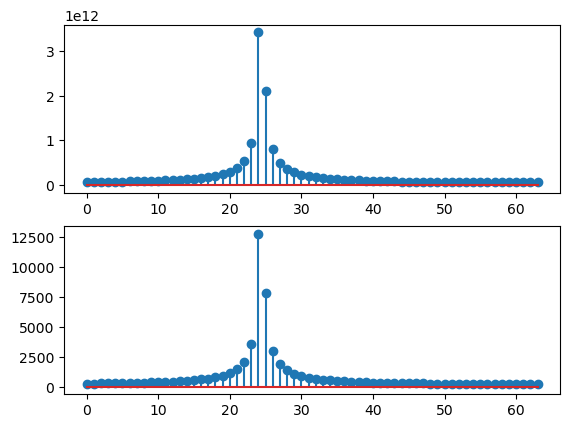

In [126]:
S = radix4_fft64(s_fixed, N)
#S = radix_4_pre(s)
plt.subplot(211)
plt.stem(np.abs(S))
plt.subplot(212)
plt.stem(np.abs(np.fft.fft(s_fixed)))

In [51]:
W64 = np.exp(-1j * 2 * np.pi * 1* np.arange(16) / 64)
print(W64)
print("fixed")
W64 = floating_to_fixed_arr(W64,0)
print(W64)

[1.        +0.j         0.99518473-0.09801714j 0.98078528-0.19509032j
 0.95694034-0.29028468j 0.92387953-0.38268343j 0.88192126-0.47139674j
 0.83146961-0.55557023j 0.77301045-0.63439328j 0.70710678-0.70710678j
 0.63439328-0.77301045j 0.55557023-0.83146961j 0.47139674-0.88192126j
 0.38268343-0.92387953j 0.29028468-0.95694034j 0.19509032-0.98078528j
 0.09801714-0.99518473j]
fixed
[32767.    +0.j 32609. -3211.j 32137. -6392.j 31356. -9512.j
 30272.-12539.j 28897.-15446.j 27244.-18204.j 25329.-20787.j
 23169.-23170.j 20787.-25330.j 18204.-27245.j 15446.-28898.j
 12539.-30273.j  9511.-31357.j  6392.-32138.j  3211.-32610.j]


In [137]:
df = pd.read_csv('/home/sakthi/oai_dev2/cmake_targets/ran_build/build/default_dft_results.csv')
print(df)

    30.000000  40.000000  50.000000  60.000000  70.000000  Unnamed: 5
0      1.3457     1.3609     1.3673     1.3685   238.3743         NaN
1      1.3122     1.3150     1.3099     1.3117   709.0656         NaN
2      1.3260     1.3267     1.3345     1.3262   127.9766         NaN
3      1.3121     1.3188     1.3136     1.2971   152.9717         NaN
4      0.3713     0.3744     0.3720     0.3698   452.3984         NaN
5      0.3127     0.3137     0.3140     0.3142   130.6559         NaN
6      0.3326     0.3337     0.3368     0.3370     0.4302         NaN
7      0.3150     0.3147     0.3148     0.3091    41.7833         NaN
8      0.3800     0.3774     0.3747     0.3777   411.2795         NaN
9      0.3098     0.3132     0.3159     0.3154    22.0015         NaN
10     0.3277     0.3301     0.3338     0.3293   225.8955         NaN
11     0.3125     0.3104     0.3125     0.3103   426.9167         NaN
12     0.3802     0.3806     0.3804     0.3702    49.4017         NaN
13     0.3105     0.

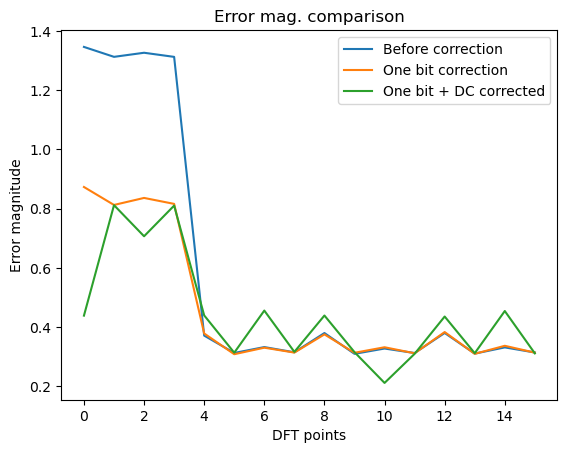

In [156]:
p = df["30.000000"].plot(legend=True,title='Error mag. comparison')
p.set_xlabel("DFT points")
p.set_ylabel("Error magnitude")
p2 = pd.read_csv('/home/sakthi/oai_dev2/cmake_targets/ran_build/build/first_four_dft_results.csv')
p2["30.000000"].plot(ax=p,legend=True)
p3 = pd.read_csv('/home/sakthi/oai_dev2/cmake_targets/ran_build/build/dft_results.csv')
p3["30.000000"].plot(ax=p,legend=True)
p.legend(['Before correction','One bit correction','One bit + DC corrected'])
fig = p.get_figure()
fig.savefig('fft_result.pdf')
fig.savefig('fft_result.png')